In [20]:
import pandas as pd
import math
import numpy as np
from scipy import stats

# ファイルを読み込む
pd_reader = pd.read_csv("data_10.csv", encoding="ANSI")
df = pd_reader

display(df)

,yyyymm,code,企業名,業種コード,時価総額,時価総額比率,翌1M収益率,PER,PBR,配当利回り,reversal,売買回転率,ボラティリティ,自己資本比率,ROE,売上高成長率,売上高営業利益率,accrual比率
0,200501,1301,極洋,50,2.316796e+10,0.000063,6.132075,189.794091,16.584526,0.001887,-1.431930,9.964968,9.798452,9.671801,22.033898,-6.904708,2.074782,-1.839077
1,200501,1331,マルハニチロ食品,50,2.944415e+10,0.000081,-1.675978,NaN,NaN,NaN,-1.812655,8.080613,8.959971,NaN,NaN,NaN,NaN,NaN
2,200501,1332,日本水産,50,9.563755e+10,0.000262,1.159420,32.363977,1.172632,0.014493,-2.771182,5.234294,6.459922,7.273836,13.135825,-1.033593,2.058652,-5.059100
3,200501,1334,マルハニチロホールディングス,50,6.030000e+10,0.000165,3.482587,NaN,NaN,NaN,0.166679,9.959333,NaN,NaN,NaN,NaN,NaN,NaN
4,200501,1352,ホウスイ,6050,8.062110e+09,0.000022,35.820896,-305.471125,22.283814,NaN,-3.994950,64.993767,10.731419,31.927423,-13.160518,-18.550438,-1.179532,2.657966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352774,202012,9991,ジェコス,6050,3.497868e+10,0.000051,-1.875000,7.930607,0.626317,0.036458,0.793522,1.528977,8.024715,55.914685,7.969035,32.833341,5.524504,-6.987187
352775,202012,9993,ヤマザワ,6100,1.914856e+10,0.000028,0.000000,-86.271605,0.676529,0.015455,-0.322500,0.719836,3.389391,55.916395,-0.782445,-3.988063,0.571512,-7.163312
352776,202012,9994,やまや,6100,2.360497e+10,0.000034,-0.459559,114.646997,0.738982,0.021140,0.307323,1.313622,9.612572,50.333228,0.643218,-0.710275,2.475501,-0.745420
352777,202012,9995,グローセル,6050,1.189206e+10,0.000017,9.555556,164.233577,0.481392,0.026667,-0.156039,1.864017,6.532688,70.537413,0.287420,-12.388195,-0.088838,-5.330464


In [4]:
# 時間推移関数
def nextym(yyyymm):
    yyyymm = yyyymm + 1
    if yyyymm % 100 == 13:
        yyyymm = yyyymm + 88
    return yyyymm

In [35]:
def TradeAlgorithm(DataFrame,GainF,LoseF):
    df = DataFrame
    GainFactors = GainF
    LoseFactors = LoseF
    end_date = 202012
    yyyymm = 200501
    SPD = []  # 存储 SPD 指标
    TOP = []  # 存储 top_rtn0 指标
    BOT = []  # 存储 bot_rtn0 指标
    top_rtn = []  # 存储 top_rtn 累积值
    bot_rtn = []  # 存储 bot_rtn 累积值

    top_sum = 0.0  # top_rtn 累积值的初始值
    bot_sum = 0.0  # bot_rtn 累积值的初始值
    n = 0

    while yyyymm <= end_date:
        tmp = df[df['yyyymm'] == yyyymm]
        GainScores = 0
        LoseScores = 0
        tmp = tmp.copy()

        for GainFactor in GainFactors:                       
            tmpf = tmp[GainFactor]
            avg = tmpf.mean()
            std = tmpf.std()
            points = []
            tmpf = tmpf.tolist()
            for i in range(len(tmpf)):

                if math.isnan(tmpf[i]):
                    point = 0
                else:
                    point = (tmpf[i] - avg)/std
                points.append(point)
            points = np.array(points)
            points = points / 11
            GainScores = GainScores + points


        for LoseFactor in LoseFactors:                       
            tmpf = tmp[LoseFactor]

            avg = tmpf.mean()
            std = tmpf.std()
            points = []
            tmpf = tmpf.tolist()
            for i in range(len(tmpf)):

                if(math.isnan(tmpf[i])):
                    point = 0
                else:
                    point = (tmpf[i] - avg)/std
                points.append(point)
            points = np.array(points)
            points = points / 11
            LoseScores = LoseScores - points

        Scores = GainScores + LoseScores


        tmp['scores'] = Scores

        top = tmp.loc[:, 'scores'].quantile(q=0.9)
        bot = tmp.loc[:, 'scores'].quantile(q=0.1)


         # 计算 top_rtn0
        tmp_2 = tmp[tmp.scores >= top]
        top_rtn0 = tmp_2.loc[:, '翌1M収益率'].mean()

        # 计算 bot_rtn0

        tmp_2 = tmp[tmp.scores <= bot]
        bot_rtn0 = tmp_2.loc[:, '翌1M収益率'].mean()

        # 计算 SPD
        spd0 = top_rtn0 - bot_rtn0
        SPD.append(spd0)
        
        # 存储 top_rtn0
        TOP.append(top_rtn0)
        top_sum += top_rtn0
        top_rtn.append(top_sum)

        # 存储 bot_rtn0
        BOT.append(bot_rtn0)
        bot_sum += bot_rtn0
        bot_rtn.append(bot_sum)

        spd_rtn = np.array(top_rtn) - np.array(bot_rtn)

        n = n + 1

        yyyymm = nextym(yyyymm)  # 更新日期
    SPD = pd.DataFrame(SPD)
    rtn = np.array(top_rtn) - np.array(bot_rtn)
    return rtn,SPD.mean(),SPD.std()

In [36]:
#課題２：ベンチマーク

Equal_weight_Gain = ['配当利回り','reversal','自己資本比率','ROE','売上高成長率','売上高営業利益率']
Equal_weight_Lose = ['PER','PBR','売買回転率','ボラティリティ','accrual比率']
Benchmark,Bench_mean,Bench_std = TradeAlgorithm(df,Equal_weight_Gain,Equal_weight_Lose)
print('Benchmark','平均:',Bench_mean.values,'標準偏差:',Bench_std.values)

Benchmark 平均: [0.52686894] 標準偏差: [3.41920441]


In [37]:
#課題３：投資策１，ただPERとPBRを選択する

Strategy1_Gain = []
Strategy1_Lose = ['PER','PBR']
Strategy1,Strategy1_mean,Strategy1_std = TradeAlgorithm(df,Strategy1_Gain,Strategy1_Lose)
print('Strategy1','平均:',Strategy1_mean.values,'標準偏差:',Strategy1_std.values)

Strategy1 平均: [0.87573808] 標準偏差: [2.14976041]


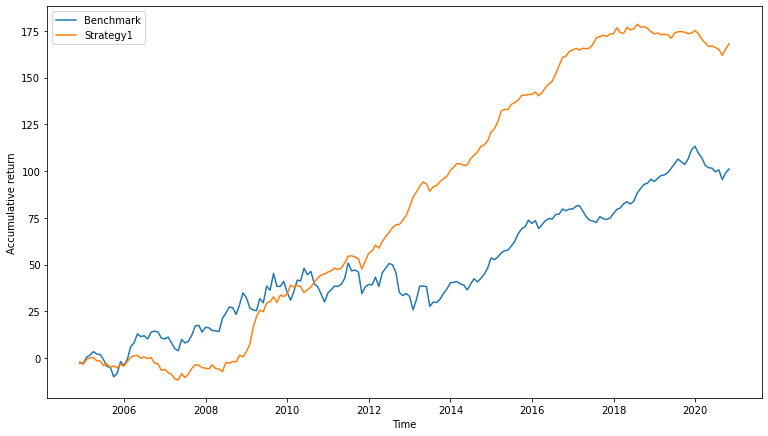

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12.8, 7.2)
x=pd.date_range('2004-11-01','2020-11-01',freq='M')

y1 = Benchmark
y2 = Strategy1
plt.plot(x,y1)
plt.plot(x,y2)

plt.xlabel("Time")
plt.ylabel("Accumulative return")
plt.legend(["BenchMark"],shadow=False,fancybox="blue")
plt.legend(["Benchmark","Strategy1"],shadow=False,fancybox="blue")
plt.show()